## <span style="color:pink">1. Preparing</span>

### Import libraries

In [1]:
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from transformers import AutoTokenizer, AutoModel



/opt/anaconda3/envs/introduction/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading datasets

In [2]:
merged_data = pd.read_excel('/Users/parisa/Desktop/AI/Final_Assignment/merged_meta_sales.xlsx')
expertReview = pd.read_excel('/Users/parisa/Desktop/AI/Final_Assignment/ExpertReviews.xlsx')

---

## <span style="color:pink">2.Transformer</span>
## All of the members did the transformer

### Converting the date column in merged_data to correct format to use it for finding the pre-released reviews

In [3]:
# Convert the 'RelDate' column to datetime format to allow for easier analysis of dates
merged_data['RelDate'] = pd.to_datetime(merged_data['RelDate'], errors='coerce')
# Remove the time from the release date and keep only the date
merged_data['RelDate'] = pd.to_datetime(merged_data['RelDate']).dt.date

# Verify the changes
print(merged_data['RelDate'].head())

0    2016-03-11
1    2012-09-14
2    2013-06-28
3    2015-05-08
4    2000-11-22
Name: RelDate, dtype: object


### To simplify the dataset and ensure the transformer operates efficiently, unnecessary columns were dropped.
### This step reduces computational overhead and focuses the transformation process on the relevant data features."

In [4]:
columns_to_drop = ['title', 'studio', 'rating', 'runtime', 'cast','director', 'title_year', 'year', 'genre', 'production_budget'
                   , 'keywords', 'creative_type', 'total_box_office','log_box_office', 'runtime_group', 'season','release_timing_binary' ]
merged_data = merged_data.drop(columns=columns_to_drop, errors='ignore')

### Converting the date column in expert reviews to correct format to use it for finding the pre-released reviews

In [5]:
# Convert the 'dateP' column to datetime format
expertReview['dateP'] = pd.to_datetime(expertReview['dateP'], errors='coerce')  # Handle invalid dates with 'coerce'

# Format the datetime to 'YYYY-MM-DD'
expertReview['dateP'] = expertReview['dateP'].dt.strftime('%Y-%m-%d')

# Display the DataFrame to confirm
print(expertReview)

                                                   url  idvscore  \
0             https://www.metacritic.com/movie/bronson     100.0   
1             https://www.metacritic.com/movie/bronson      90.0   
2             https://www.metacritic.com/movie/bronson      90.0   
3             https://www.metacritic.com/movie/bronson      83.0   
4             https://www.metacritic.com/movie/bronson      80.0   
...                                                ...       ...   
238968  https://www.metacritic.com/movie/spirited-away      80.0   
238969  https://www.metacritic.com/movie/spirited-away      75.0   
238970  https://www.metacritic.com/movie/spirited-away      75.0   
238971  https://www.metacritic.com/movie/spirited-away      75.0   
238972  https://www.metacritic.com/movie/spirited-away      75.0   

                  reviewer dateP  \
0         "Andrew O'Hehir"   NaN   
1             'A.O. Scott'   NaN   
2                     None   NaN   
3            'Noel Murray'   NaN   
4  

/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_78658/1756546455.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  expertReview['dateP'] = pd.to_datetime(expertReview['dateP'], errors='coerce')  # Handle invalid dates with 'coerce'


### Code Explanation:
This code filters the dataset by removing rows where the ⁠ dateP ⁠ column has missing (NaN) values. This ensures that only reviews with a valid release date are retained in the dataset. 

The purpose is to focus exclusively on pre-released reviews, as the presence of a date (⁠ dateP ⁠) is critical for identifying and analyzing such reviews.

In [6]:
# Drop rows where 'dateP' has NaN values
expertReview = expertReview.dropna(subset=['dateP'])
# Display the cleaned DataFrame to confirm
expertReview.head(10)

,url,idvscore,reviewer,dateP,Rev
40,https://www.metacritic.com/movie/a-screaming-man,90.0,'Manohla Dargis',2011-04-14,"'It s a modest film, if only in scale and app..."
41,https://www.metacritic.com/movie/a-screaming-man,83.0,'Eric Kohn',2011-04-12,"'At its core, A Screaming Man emphasizes the ..."
42,https://www.metacritic.com/movie/a-screaming-man,80.0,'Robert Koehler',2013-05-26,'Haroun s tender but unsentimental regard for...
43,https://www.metacritic.com/movie/a-screaming-man,80.0,'David Fear',2011-04-12,'A collective sense of psychological turmoil ...
44,https://www.metacritic.com/movie/a-screaming-man,70.0,None,2011-04-12,'Haroun is uninterested in big war scenes and...
45,https://www.metacritic.com/movie/a-screaming-man,60.0,None,2011-04-16,'The first half-hour is as evocative as (and ...
46,https://www.metacritic.com/movie/a-screaming-man,60.0,'Joe Neumaier',2011-04-15,'Haroun is achingly conscious of day-to-day d...
47,https://www.metacritic.com/movie/a-screaming-man,50.0,'Nick Pinkerton',2011-04-12,'The characterizations never comfortably acco...
48,https://www.metacritic.com/movie/lovers-of-hate,91.0,'Eric Kohn',2011-02-10,'Never indulging in outright scare tactics or...
49,https://www.metacritic.com/movie/lovers-of-hate,90.0,'Jeannette Catsoulis',2011-02-10,"'Smartly written and flawlessly acted, Lovers..."


### To simplify the dataset and ensure the transformer operates efficiently, unnecessary columns were dropped.


In [7]:
columns_to_drop = ['idvscore', 'reviewer']
exper = expertReview.drop(columns=columns_to_drop, errors='ignore', inplace=True)

### The code preprocesses the review text data by cleaning the ⁠ Rev ⁠ column in the ⁠ expertReview ⁠ DataFrame. It removes unwanted characters while retaining only alphabets, spaces, dots, and commas, ensuring the text is standardized and ready for use in transformer-based models.

In [8]:
# Function to clean text
def clean_text(text):
    # Keep only alphabets, dot (.), and comma (,)
    return re.sub(r"[^a-zA-Z.,\s]", "", text)

# Assuming your column is named 'Rev' in the DataFrame expertReview
expertReview['Rev'] = expertReview['Rev'].apply(clean_text)

### This code merges the expertReview and merged_data DataFrames on the "url" column to combine review data with release date information. After merging, it converts the RelDate (release date) and dateP (review date) columns to datetime format and filters for pre-release reviews by selecting rows where the review date is earlier than the release date.

In [9]:
merged_reviews = expertReview.merge(merged_data[['url', 'RelDate']], on='url', how='inner')

# Convert to datetime if needed
merged_reviews['RelDate'] = pd.to_datetime(merged_reviews['RelDate'])
merged_reviews['dateP'] = pd.to_datetime(merged_reviews['dateP'])
# Filter pre-release
pre_release_reviews = merged_reviews[merged_reviews['dateP'] < merged_reviews['RelDate']]


### This code improves the cleaning process for the Rev column because the first attempt didn't work well. It makes the text lowercase, removes HTML tags, and extra spaces to ensure the reviews are clean and ready

In [10]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

pre_release_reviews['Rev_clean'] = pre_release_reviews['Rev'].apply(clean_text)


/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_78658/3283522351.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_release_reviews['Rev_clean'] = pre_release_reviews['Rev'].apply(clean_text)


### Processesing review text using a pre-trained DistilBERT model to generate embeddings, which are numerical representations of the text's meaning. The embeddings are added to the DataFrame and saved for future use.

In [11]:
reviews = pre_release_reviews['Rev_clean'].tolist()
# GPU or CPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')
model.to(device)
model.eval()  # Put the model in evaluation mode

# Batching parameters
batch_size = 128  # Adjust this to fit your memory constraints
all_embeddings = []

# Process in batches
with torch.no_grad():
    for i in range(0, len(reviews), batch_size):
        batch = reviews[i:i+batch_size]
        # Tokenize batch
        inputs = tokenizer(batch, truncation=True, padding=True, return_tensors='pt')
        
        # Move inputs to GPU if available
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Forward pass
        outputs = model(**inputs)
        
        # Extract [CLS] embedding: outputs.last_hidden_state shape [batch_size, seq_len, hidden_size]
        # CLS token embedding is at index 0
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(batch_embeddings)

# Combine all embeddings
review_embeddings = np.vstack(all_embeddings)  # shape: [num_reviews, hidden_size]

# Attach embeddings to pre_release_reviews DataFrame
# For DistilBERT, hidden_size is typically 768
hidden_size = review_embeddings.shape[1]

for idx in range(hidden_size):
    pre_release_reviews[f'emb_{idx}'] = review_embeddings[:, idx]

# Now pre_release_reviews contains the embedding columns.
# Group by movie URL or any identifier to get a single vector per movie.
movie_embeddings = pre_release_reviews.groupby('url').mean(numeric_only=True).reset_index()

# Save or use the resulting DataFrame to check if we need in the main notebook
pre_release_reviews.to_csv("pre_release_with_embeddings.csv", index=False)


Using device: cpu


/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_78658/1308878765.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_release_reviews[f'emb_{idx}'] = review_embeddings[:, idx]
/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_78658/1308878765.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_release_reviews[f'emb_{idx}'] = review_embeddings[:, idx]
/var/folders/vj/8m5jj9z91zx9r3qq99js26bh0000gn/T/ipykernel_78658/1308878765.py:42: SettingWithCopyWarning: 
A value is trying to b

### Why We Skipped the Warning:
The `SettingWithCopyWarning` occurs because the DataFrame being modified is a view of another DataFrame, and changes might not always propagate as expected. We skipped this warning because the changes are intentional, and the workflow ensures that the modifications are directly used or saved without any unexpected behavior. Additionally, we observed in our lecturer's GitHub repository that this warning is normal in similar cases, so addressing it is unnecessary in this context.

### Using CPU for Processing:
Due to the unavailability of a GPU in our system, we proceeded with the computations on the CPU. While GPUs provide faster parallel processing for tasks like transformer-based embeddings, the CPU serves as a reliable alternative for completing the task, albeit with increased computation time. This ensures the workflow remains consistent and functional regardless of hardware constraints.

In [12]:
pre_release_reviews

,url,dateP,Rev,RelDate,Rev_clean,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
1,https://www.metacritic.com/movie/viva-riva!,2011-06-09,"Digitally shot, the film looks great, and the...",2011-06-10,"digitally shot, the film looks great, and the ...",0.086419,-0.226540,0.044605,-0.149472,-0.020261,...,0.007105,-0.248623,0.030840,-0.171039,-0.211481,0.133665,-0.015730,-0.043628,0.466814,0.039145
2,https://www.metacritic.com/movie/viva-riva!,2011-06-09,"As gutpunch storytelling, Viva Riva delivers ...",2011-06-10,"as gutpunch storytelling, viva riva delivers m...",0.043528,-0.200920,-0.044656,-0.107835,-0.043621,...,0.032889,-0.185356,0.078451,-0.098685,-0.145477,0.151468,0.132764,-0.095357,0.573977,0.059903
3,https://www.metacritic.com/movie/viva-riva!,2011-06-07,The first major motion picture to come out of...,2011-06-10,the first major motion picture to come out of ...,-0.102624,-0.002317,-0.146271,-0.244265,-0.000687,...,0.048167,-0.233665,0.242829,-0.047948,0.259062,-0.198621,-0.213442,-0.290814,0.382885,0.185207
4,https://www.metacritic.com/movie/viva-riva!,2011-06-06,Driven by its charismatic upstart gangster pr...,2011-06-10,driven by its charismatic upstart gangster pro...,0.059022,-0.156837,0.032272,-0.177261,-0.109761,...,0.224479,-0.241883,-0.013543,-0.174373,-0.190157,0.108192,0.085021,-0.119983,0.311995,0.100779
6,https://www.metacritic.com/movie/viva-riva!,2011-06-09,"Frenetic, sleazy, and entertaining as all hel...",2011-06-10,"frenetic, sleazy, and entertaining as all hell...",-0.084730,-0.387943,0.101713,-0.141925,-0.137042,...,0.005229,-0.338156,-0.004638,-0.225518,-0.150358,0.118812,-0.001008,-0.178593,0.601120,0.170336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94871,https://www.metacritic.com/movie/denial,2016-09-29,The absence of an emotional catharsis in the ...,2016-09-30,the absence of an emotional catharsis in the f...,-0.090895,-0.069728,-0.143942,-0.167077,0.004548,...,0.143239,-0.274073,0.010319,-0.083376,-0.130333,0.100080,-0.005920,-0.175576,0.335521,0.350860
94872,https://www.metacritic.com/movie/denial,2016-09-16,What s most disturbing is Jackson s pedestria...,2016-09-30,what s most disturbing is jackson s pedestrian...,0.113111,-0.024829,-0.245150,-0.099908,0.011386,...,0.045346,-0.101633,-0.050628,-0.175845,-0.056274,-0.040589,0.071167,-0.186722,0.485098,0.222214
94873,https://www.metacritic.com/movie/denial,2016-09-16,For all the powerful relevance of its subject...,2016-09-30,"for all the powerful relevance of its subject,...",0.120504,0.022715,-0.078737,-0.199565,-0.073347,...,0.071664,-0.202788,-0.101760,-0.136323,-0.171446,0.146058,0.045478,-0.080100,0.500502,0.342929
94874,https://www.metacritic.com/movie/denial,2016-09-16,Under the workmanlike direction of Mick Jacks...,2016-09-30,under the workmanlike direction of mick jackso...,0.063063,-0.120179,0.077126,-0.225562,-0.165565,...,0.061650,-0.340784,0.230172,0.017041,-0.004235,0.223802,-0.120174,-0.247972,0.556635,0.328114


In [13]:
movie_embeddings

,url,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,https://www.metacritic.com/movie/10-cloverfiel...,-0.074867,-0.188120,-0.018028,-0.105430,0.008553,-0.158412,0.199432,0.217958,-0.007847,...,-0.049848,-0.255575,0.071203,-0.102021,-0.029906,0.115446,0.018435,-0.063111,0.461652,0.312659
1,https://www.metacritic.com/movie/10-years,-0.074195,-0.115659,-0.032398,-0.089929,-0.024097,-0.114885,0.175607,0.268838,-0.008106,...,-0.015590,-0.233898,0.063655,-0.104223,-0.005887,-0.007441,0.015958,-0.084627,0.496124,0.220430
2,https://www.metacritic.com/movie/100-bloody-acres,-0.014305,-0.125369,-0.029566,-0.089660,-0.130013,-0.197666,0.235846,0.320986,0.021316,...,-0.123202,-0.257384,0.000879,-0.039223,-0.032115,0.158877,-0.008304,0.005293,0.529215,0.265804
3,https://www.metacritic.com/movie/1001-grams,-0.223072,-0.119134,-0.231608,-0.171858,-0.086744,0.035033,0.179242,0.197496,-0.149813,...,0.069918,-0.250097,0.099772,-0.164574,0.044402,0.031151,0.075752,-0.015709,0.419366,0.279952
4,https://www.metacritic.com/movie/12-hour-shift,-0.034319,-0.152494,-0.104484,-0.138410,0.006330,-0.034973,0.219170,0.177016,-0.006638,...,-0.096182,-0.277635,0.053919,-0.133052,-0.087455,0.037785,0.051550,-0.045847,0.525605,0.316326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4110,https://www.metacritic.com/movie/zombieland-do...,0.042096,-0.193791,0.026169,-0.066860,-0.117428,-0.194587,0.239898,0.258606,0.017160,...,-0.099699,-0.177931,0.078580,-0.054278,0.012946,0.125200,-0.002364,0.020058,0.559686,0.324585
4111,https://www.metacritic.com/movie/zookeeper,-0.035978,-0.056422,-0.031902,-0.085321,-0.056189,-0.143668,0.255980,0.381507,-0.100227,...,-0.116007,-0.233686,0.055901,-0.120772,0.038815,0.129076,-0.049585,-0.053165,0.592864,0.323490
4112,https://www.metacritic.com/movie/zoolander-2,0.018349,-0.137308,0.012636,-0.053967,-0.100960,-0.218027,0.211496,0.347877,-0.078569,...,-0.137683,-0.201909,0.111038,-0.109137,0.062401,0.131901,-0.018030,-0.033374,0.581107,0.349353
4113,https://www.metacritic.com/movie/zoom-2016,0.017212,-0.109956,-0.139065,-0.040434,-0.028730,-0.116733,0.132957,0.149773,0.061292,...,-0.061862,-0.377018,0.149726,-0.116956,-0.036899,0.071110,0.064401,0.047250,0.553393,0.253544


### Conclusion:
Initially, the dataset contained 61,181 rows, as each review was treated independently. After grouping by the movie URL (or identifier) and averaging the embeddings, the dataset was reduced to 4,115 rows, representing one embedding vector per movie. This transformation significantly reduces redundancy while maintaining the aggregated semantic representation of all reviews for each movie.

---

## <span style="color:pink">3.PCA</span>

## <span style="color:pink">3.1Finding the best components number: 
</span>


### We extracted all embedding columns from the movie_embeddings  by identifying columns that start with `emb_`. This step ensures that only numerical embedding data is used for PCA, excluding non-numeric columns like `url`.

In [14]:
# Extract the embedding columns (all numeric)
embedding_cols = [col for col in movie_embeddings.columns if col.startswith('emb_')]
X = movie_embeddings[embedding_cols].values


### Since we needed to identify the optimal number of principal components for PCA, we initialized and fitted the PCA model on the extracted embedding data (`X`). This step computes the necessary components and their variance contributions, which are essential for deciding the number of components to retain.

In [15]:
# Exclude non-numeric columns (e.g., 'url')
X = movie_embeddings.iloc[:, 1:]  
pca = PCA()
pca.fit(X)

PCA()

## Conclusion: 
- This step sets up the PCA model, enabling us to analyze the variance explained by each component to find the best number of components for dimensionality reduction.
### ===============

### The explained variance ratio for each principal component was calculated, and its cumulative sum was computed. This helps determine the proportion of total variance captured by a specified number of components.

In [16]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum() 

In [17]:
cumulative_variance = explained_variance.cumsum()
print(cumulative_variance)

[0.13411672 0.22720706 0.29548228 0.33760175 0.37495255 0.41026267
 0.4410441  0.4695525  0.49412096 0.515956   0.5358168  0.55454457
 0.57199943 0.588838   0.6039681  0.61740685 0.6300707  0.64195234
 0.65256995 0.6627937  0.67238307 0.68161625 0.69048166 0.69859666
 0.7064137  0.71411103 0.72155684 0.7279122  0.7340423  0.7399825
 0.745464   0.75064105 0.7555348  0.76015294 0.764668   0.76905894
 0.7733227  0.7775308  0.7815956  0.78555906 0.7892975  0.79282504
 0.7962439  0.79959023 0.8028061  0.8059296  0.80896467 0.8119686
 0.81488305 0.8176864  0.8204116  0.8230597  0.82568634 0.828214
 0.8306911  0.8330645  0.83539784 0.8377016  0.8399429  0.84215313
 0.8443518  0.84650844 0.8485586  0.8505255  0.8524812  0.85442203
 0.856301   0.8581538  0.85996616 0.86168194 0.8633882  0.865041
 0.86667037 0.86828667 0.86985344 0.87140244 0.8729366  0.87444973
 0.8759235  0.87735236 0.8787428  0.8801267  0.88149047 0.8828183
 0.8841147  0.8853873  0.8866257  0.8878536  0.88906616 0.89026123
 0

## Conclusion: 
- The cumulative variance values indicate how much total variance is captured as the number of components increases. This allows us to identify the optimal number of components needed to retain a desired percentage of variance, such as 90% or 95%, ensuring efficient dimensionality reduction without significant loss of information.

In [18]:
# For 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components for 90% variance: {n_components_90}")

# For 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components for 95% variance: {n_components_95}")

Number of components for 90% variance: 99
Number of components for 95% variance: 177


## Conclusion: 
- To capture 90% of the total variance, 99 components are required, while 177 components are needed to retain 95% of the variance. This provides a clear choice for dimensionality reduction, balancing the trade-off between computational efficiency and information retention.

In [19]:
# For 90% variance
n_components = n_components_90  # or use n_components_95 for 95% variance
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X)

print(f"Shape of reduced data: {X_reduced.shape}")

Shape of reduced data: (4115, 99)


## Conclusion: 
- We selected 90% variance as the threshold for dimensionality reduction because it provides a balance between retaining most of the meaningful information in the data and reducing computational complexity. Capturing 90% ensures that the majority of the variance is preserved without the need to retain excessive dimensions, which could lead to inefficiency and redundancy.

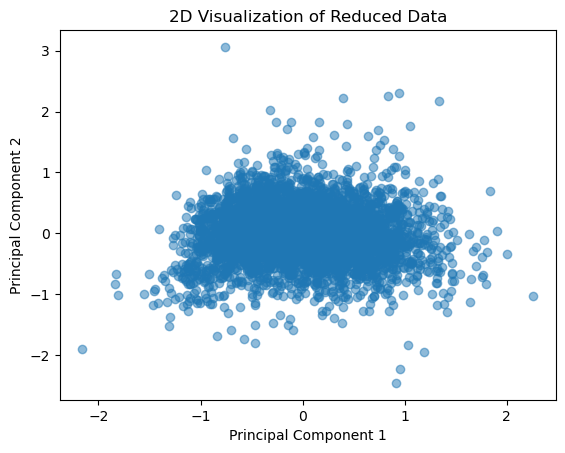

In [20]:
# Example for 2D visualization
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Reduced Data')
plt.show()

## Conclusion: 
From the plot, we can understand:
1. Most of the data points are closely clustered in the center, indicating that they are similar in terms of the first two principal components.
2. Some points are spread out, which suggests variability or potential outliers in the data.
3. The overall distribution of the data in the reduced 2D space, which provides insight into its structure and relationships between points.

## <span style="color:pink">3.2 Implement PCA
</span>


In [21]:
# Perform PCA
n_components = 10  
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X)  


### We chose the first 10 principal components as they capture the most variance among the features, providing a simplified representation of the data while retaining the most critical information for analysis and interpretation.

In [22]:
# Create a DataFrame for PCA features (numerical featuers) 
pca_columns = [f'pca_{i}' for i in range(n_components)]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)

In [23]:
# Add the 'url' back to pca_df so we can merge
pca_df['url'] = movie_embeddings['url'].values

In [24]:
pca_df

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,url
0,-0.316456,0.093970,0.243271,-0.026334,-0.242160,0.098554,0.220553,-0.101992,0.100413,0.265553,https://www.metacritic.com/movie/10-cloverfiel...
1,0.271335,0.282407,0.101853,-0.177299,0.104157,0.248039,-0.026053,-0.041329,0.458178,0.334793,https://www.metacritic.com/movie/10-years
2,-0.851014,-0.232373,-0.029580,-0.096503,0.107262,-0.257108,-0.443127,-0.098747,0.440290,-0.109246,https://www.metacritic.com/movie/100-bloody-acres
3,0.958757,-0.107041,-0.036577,-0.309297,0.513934,0.489606,-0.066192,-0.240246,-0.135368,-0.575068,https://www.metacritic.com/movie/1001-grams
4,-0.379510,0.190700,0.673141,-0.076803,0.186418,0.213442,-0.191798,0.329229,0.169817,0.267888,https://www.metacritic.com/movie/12-hour-shift
...,...,...,...,...,...,...,...,...,...,...,...
4110,-1.252945,-0.521868,-0.097185,0.091821,-0.298644,-0.059417,0.051030,0.013253,0.148714,0.249260,https://www.metacritic.com/movie/zombieland-do...
4111,-1.136420,0.109232,-0.563529,-0.279602,0.243113,-0.064388,0.001598,-0.104594,-0.094777,-0.153634,https://www.metacritic.com/movie/zookeeper
4112,-1.148222,-0.145785,-0.663662,-0.009199,0.075895,0.078799,-0.125591,-0.045465,0.025777,0.052998,https://www.metacritic.com/movie/zoolander-2
4113,-0.652103,-0.818520,0.492668,-0.474557,-0.175497,-0.377389,-0.181461,-0.014304,0.266331,-0.310694,https://www.metacritic.com/movie/zoom-2016


### Save the dataframe to use in main notebook

In [25]:
file_path = '/Users/parisa/Desktop/AI/Final_Assignment/expert_transformer_1.xlsx'
pca_df.to_excel(file_path, index=False)